In [ ]:
pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d mczielinski/bitcoin-historical-data

 95% 95.0M/100M [00:00<00:00, 136MB/s]
100% 100M/100M [00:00<00:00, 159MB/s] 


In [ ]:
! unzip  '/content/bitcoin-historical-data.zip' -d '/content/bitcoin-historical-data'

Archive:  /content/bitcoin-historical-data.zip
  inflating: /content/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv  


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.utils import make_grid
import torch.utils.data as data
from torch.autograd import Variable
%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

In [ ]:
df = pd.read_csv('/content/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df.head()

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df['date']=df['Timestamp'].dt.date
df2 = df.dropna()

In [ ]:
df2.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
478,2011-12-31 15:50:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
547,2011-12-31 16:59:00,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
548,2011-12-31 17:00:00,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
1224,2012-01-01 04:16:00,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01


In [ ]:
# daily
df_d = df2.groupby(['date']).mean(['Weighted_Price']).reset_index()
df_d['date'] = pd.to_datetime(df_d['date'])
df_d.set_index(['date'], inplace=True)
df_d = df_d[['Weighted_Price']]
# monthly
df_m = df_d.resample('M').mean(['Weighted_Price'])

Text(0.5, 0, 'Timestamp')

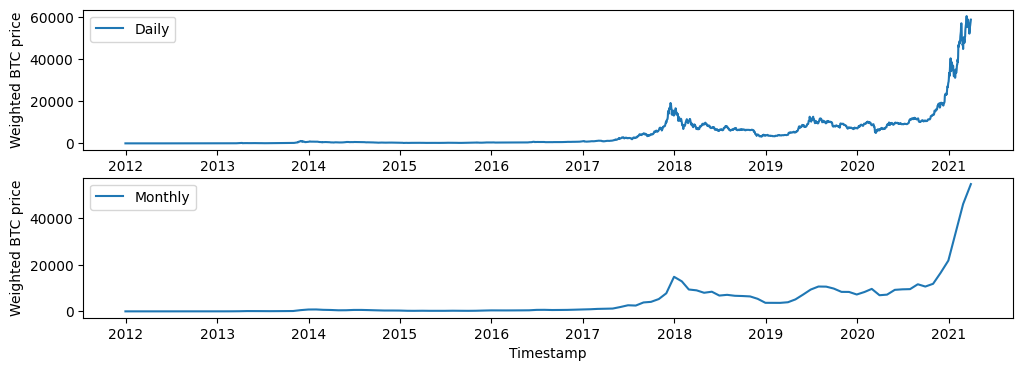

In [ ]:
#plot
plt.figure(figsize=(12,4))
plt.subplot(211)
plt.plot(df_d, label='Daily')
plt.legend()
plt.ylabel('Weighted BTC price')
plt.subplot(212)
plt.plot(df_m, label='Monthly')
plt.legend()
plt.ylabel('Weighted BTC price')
plt.xlabel('Timestamp')

In [ ]:
timeseries = df2[["Close"]].values.astype('float32')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
mms = MinMaxScaler()

In [ ]:
timeseries = mms.fit_transform(timeseries)

In [ ]:
train_size = int(len(timeseries))
test_size = len(timeseries) - train_size
print(train_size)
print(test_size)
train, test = timeseries[train_size-10000:train_size-1000], timeseries[train_size-1000:]
print(len(train))
print(len(test))

3613769
0
9000
1000


In [ ]:
def My_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [ ]:
lookback = 4
X_train, y_train = My_dataset(train, lookback=lookback)
X_test, y_test = My_dataset(test, lookback=lookback)

In [ ]:
class BitcoinModel(nn.Module):
    def __init__(self):
        super(BitcoinModel, self).__init__()
        self.num_layers = 1
        self.hidden_size = 50

        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, _) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.linear(hn)
        return out

In [ ]:
model = BitcoinModel().to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [ ]:
batch_size = 64
train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=batch_size,shuffle=True)
test_loader = data.DataLoader(data.TensorDataset(X_test, y_test), batch_size=batch_size,shuffle=True)

In [ ]:
! pip install torchinfo

In [ ]:
!pip install pytorch-ignite --quiet

In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix, MeanSquaredError, RootMeanSquaredError
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [ ]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [ ]:
metrics = { "mse" : MeanSquaredError()}

In [ ]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics,device=device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device=device)

In [ ]:
training_history = {'mse':[]}
test_history = {'mse':[]}
last_epoch = []

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    loss = metrics['mse']
    last_epoch.append(0)
    training_history['mse'].append(loss)
    if trainer.state.epoch % 100 == 0:
      print("Результат обучения - Эпоха: {}  ошибка: {:.7f}"
          .format(trainer.state.epoch,loss))

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    loss = metrics['mse']
    test_history['mse'].append(loss)
    if trainer.state.epoch % 100 == 0:
      print("Результат валидации - Эпоха: {}  ошибка: {:.7f}"
          .format(trainer.state.epoch, loss))

In [ ]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=1, filename_prefix='best',
    score_name="mse",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [ ]:
trainer.run(train_loader, max_epochs=2000)

Результат обучения - Эпоха: 100  ошибка: 0.0000015
Результат валидации - Эпоха: 100  ошибка: 0.0000010
Результат обучения - Эпоха: 200  ошибка: 0.0000032
Результат валидации - Эпоха: 200  ошибка: 0.0000032
Результат обучения - Эпоха: 300  ошибка: 0.0000011
Результат валидации - Эпоха: 300  ошибка: 0.0000008
Результат обучения - Эпоха: 400  ошибка: 0.0000053
Результат валидации - Эпоха: 400  ошибка: 0.0000058
Результат обучения - Эпоха: 500  ошибка: 0.0000036
Результат валидации - Эпоха: 500  ошибка: 0.0000029
Результат обучения - Эпоха: 600  ошибка: 0.0000015
Результат валидации - Эпоха: 600  ошибка: 0.0000009
Результат обучения - Эпоха: 700  ошибка: 0.0000009
Результат валидации - Эпоха: 700  ошибка: 0.0000005
Результат обучения - Эпоха: 800  ошибка: 0.0000019
Результат валидации - Эпоха: 800  ошибка: 0.0000015
Результат обучения - Эпоха: 900  ошибка: 0.0000030
Результат валидации - Эпоха: 900  ошибка: 0.0000030
Результат обучения - Эпоха: 1000  ошибка: 0.0000013
Результат валидации -

State:
	iteration: 282000
	epoch: 2000
	epoch_length: 141
	max_epochs: 2000
	output: 9.490717616245092e-07
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [ ]:
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('/content/models')))
print("Модель загружена")

Модель загружена


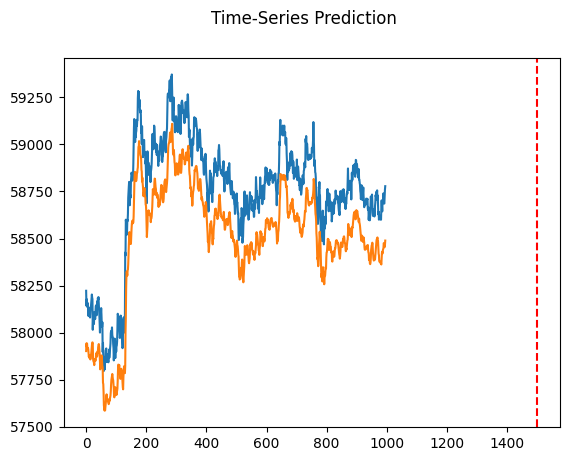

In [ ]:
# model.eval()
train_predict = model(X_test)

data_predict = train_predict.data.numpy()
dataY_plot = y_test.data.numpy()

data_predict = mms.inverse_transform(data_predict)
dataY_plot = mms.inverse_transform(dataY_plot)

plt.axvline(x=1500, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
# model.eval()

test_predict = model(X_test)

data_predict = train_predict.data.numpy()
dataY_plot = y_test.data.numpy()

data_predict = mms.inverse_transform(data_predict)
dataY_plot = mms.inverse_transform(dataY_plot)

plt.axvline(x=1500, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()